In [17]:
import toml
import math
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import sqlalchemy as sa
import datetime
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

sns.set_theme()
mpl.rcParams["text.usetex"] = False

In [18]:
config = toml.load("./db.toml")['psql']
connection_string = f"postgresql://{config['user']}:{config['password']}@{config['host']}:{config['port']}/{config['database']}"

In [19]:
conn = sa.create_engine(connection_string)

In [20]:
def cdf(series: pd.Series) -> pd.DataFrame:
    """ calculates the cumulative distribution function of the given series"""
    return pd.DataFrame.from_dict({
        series.name: np.append(series.sort_values(), series.max()),
        "cdf": np.linspace(0, 1, len(series) + 1)
    })

In [147]:
def monday_of_week(week_num):
    """
    Returns the date of the Monday for a given week number.

    Args:
    week_num (int): Week number for which to find the Monday date.

    Returns:
    datetime.date object: Date of the Monday for the given week number.
    """
    # Get the date of the first day of the year
    year = datetime.datetime.now().year  # or specify a specific year
    first_day_of_year = datetime.date(year, 1, 1)

    # Calculate the date of the Monday for the given week number
    days_to_monday = first_day_of_year.weekday()
    days_to_first_week = 7 - days_to_monday
    days_to_week = (week_num - 1) * 7
    days_to_target_week = days_to_first_week + days_to_week
    monday_date = first_day_of_year + datetime.timedelta(days_to_target_week)

    return monday_date

In [21]:
sns.set_theme()
dpi = 150

In [6]:
date_min = "2023-03-13"
date_max = "2023-03-20"

In [25]:
query = f"""
SELECT
    n.region,
    r.duration,
    r.created_at,
    DATE(r.created_at)::TEXT date,
    r.error IS NOT NULL has_error
FROM retrievals r
    INNER JOIN nodes n ON r.node_id = n.id
WHERE r.created_at >= '{date_min}'
  AND r.created_at < '{date_max}'
ORDER BY r.created_at
"""
retrievals = pd.read_sql_query(query, con=conn)
retrievals

,region,duration,created_at,date,has_error
0,eu-central-1,0.353165,2023-03-13 00:00:18.009581+00:00,2023-03-13,False
1,sa-east-1,0.679142,2023-03-13 00:00:18.359076+00:00,2023-03-13,False
2,ap-southeast-2,1.115853,2023-03-13 00:00:18.879471+00:00,2023-03-13,False
3,ap-south-1,1.233887,2023-03-13 00:00:18.984824+00:00,2023-03-13,False
4,af-south-1,1.549313,2023-03-13 00:00:19.344990+00:00,2023-03-13,False
...,...,...,...,...,...
106615,us-west-1,0.212420,2023-03-19 23:59:03.507075+00:00,2023-03-19,False
106616,eu-central-1,0.298543,2023-03-19 23:59:03.623025+00:00,2023-03-19,False
106617,ap-south-1,0.800439,2023-03-19 23:59:04.220889+00:00,2023-03-19,False
106618,sa-east-1,1.038245,2023-03-19 23:59:04.384071+00:00,2023-03-19,False


In [27]:
query = f"""
SELECT
    n.region,
    p.duration,
    p.created_at,
    DATE(p.created_at)::TEXT date,
    p.error IS NOT NULL has_error
FROM provides p
    INNER JOIN nodes n ON p.node_id = n.id
WHERE p.created_at >= '{date_min}'
  AND p.created_at < '{date_max}'
ORDER BY p.created_at
"""
provides = pd.read_sql_query(query, con=conn)
provides

,region,duration,created_at,date,has_error
0,us-west-1,10.938516,2023-03-13 00:00:07.561428+00:00,2023-03-13,False
1,sa-east-1,8.439304,2023-03-13 00:00:27.901633+00:00,2023-03-13,False
2,eu-central-1,2.997641,2023-03-13 00:00:42.057464+00:00,2023-03-13,False
3,ap-south-1,13.039503,2023-03-13 00:01:06.798719+00:00,2023-03-13,False
4,af-south-1,19.013139,2023-03-13 00:01:37.369423+00:00,2023-03-13,False
...,...,...,...,...,...
21320,eu-central-1,7.813193,2023-03-19 23:58:02.233044+00:00,2023-03-19,False
21321,ap-southeast-2,5.853802,2023-03-19 23:58:19.619717+00:00,2023-03-19,False
21322,ap-south-1,3.627227,2023-03-19 23:58:35.167957+00:00,2023-03-19,False
21323,af-south-1,6.529010,2023-03-19 23:58:53.230564+00:00,2023-03-19,False


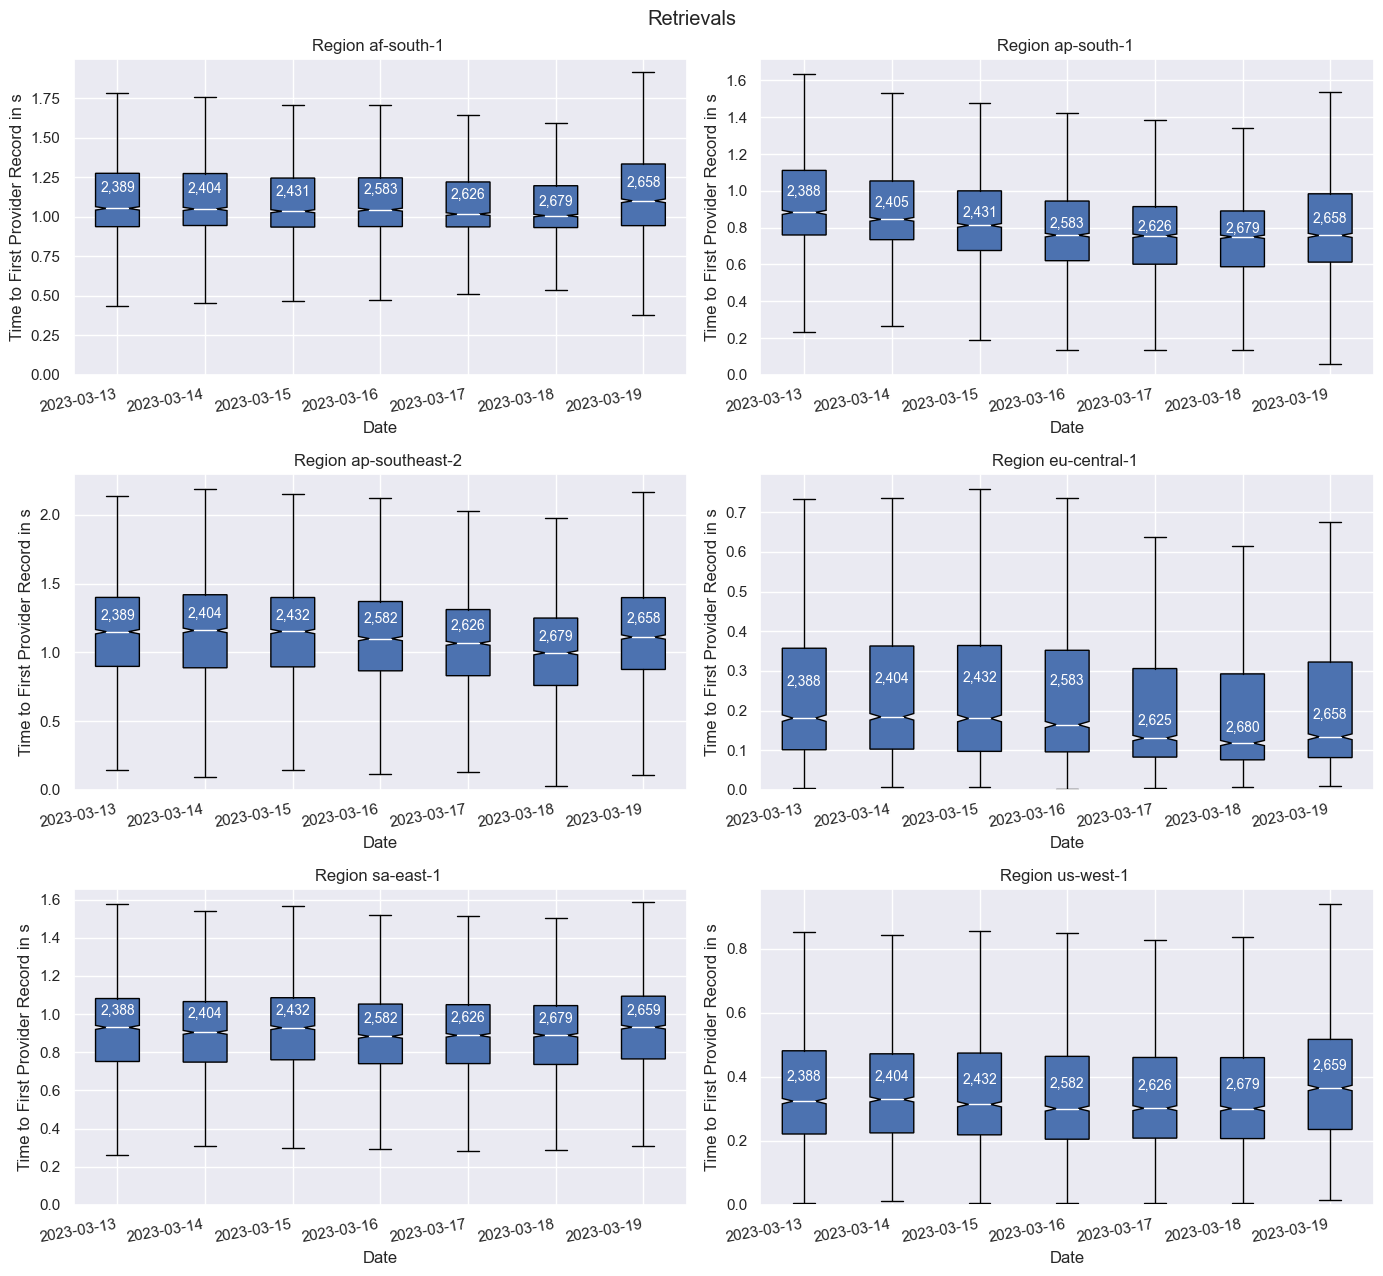

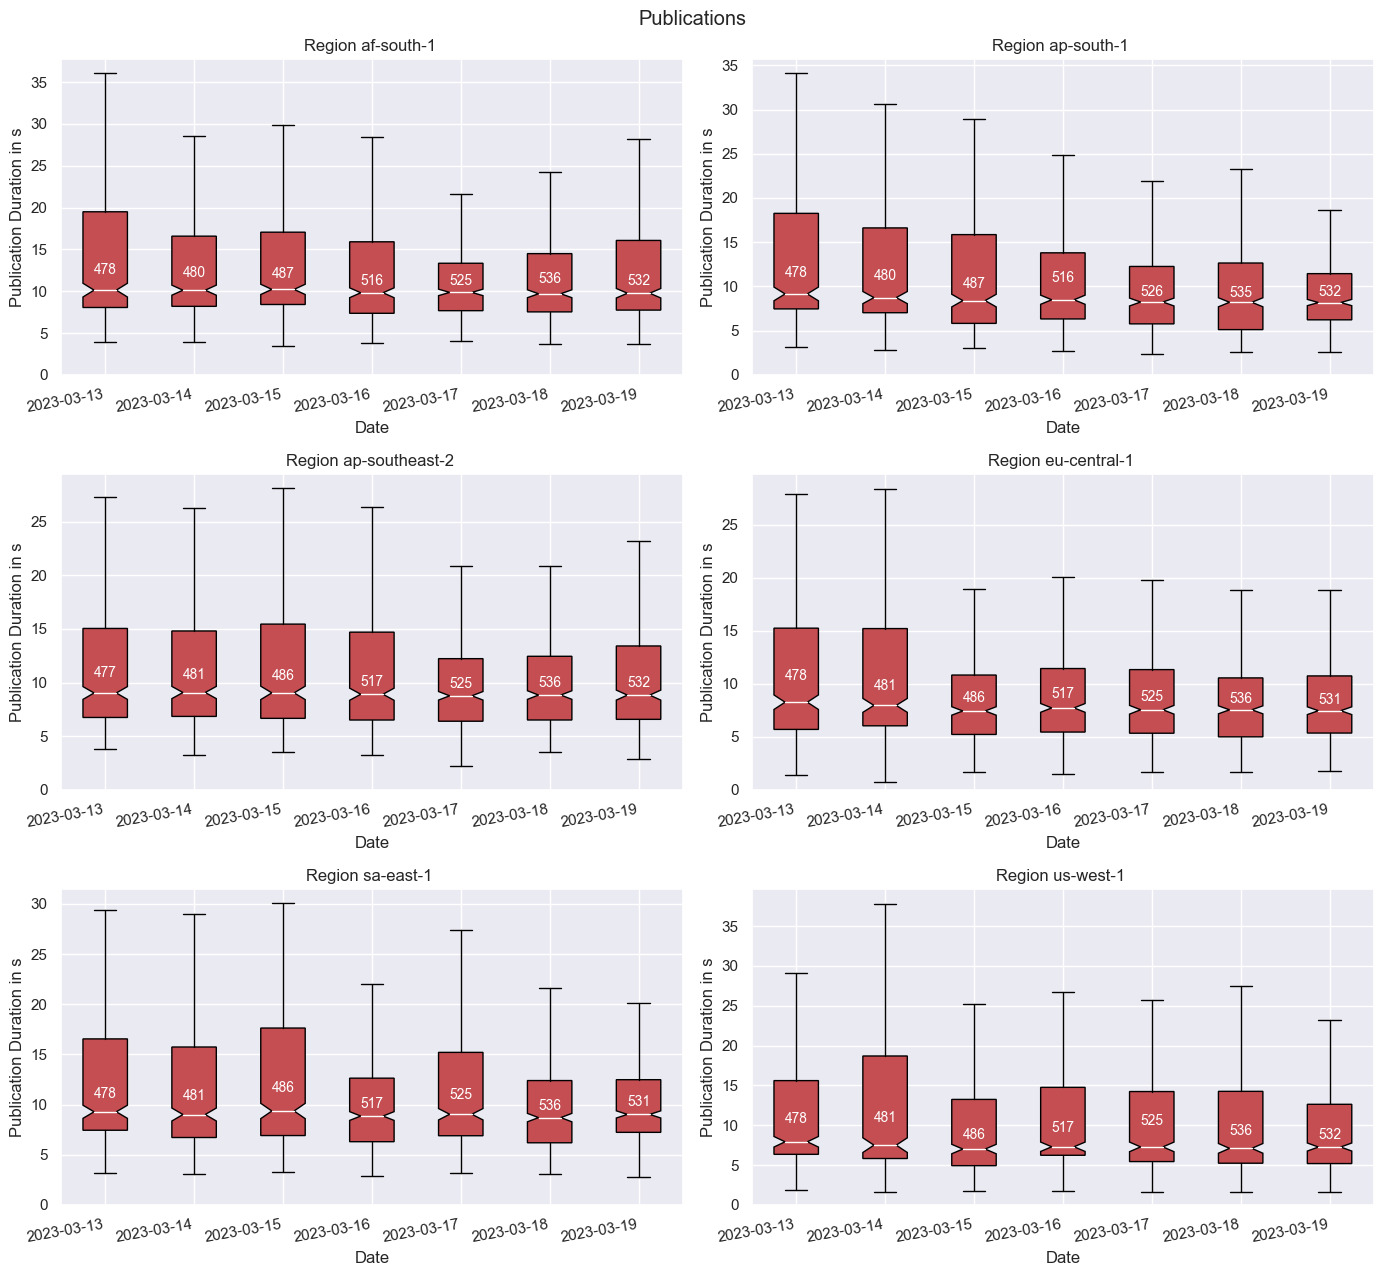

In [9]:
plots = [
    {
        "data": retrievals,
        "boxcolor": "b",
        "ylabel": "Time to First Provider Record in s",
        "title": "Retrievals"
    },
    {
        "data": provides,
        "boxcolor": "r",
        "ylabel": "Publication Duration in s",
        "title": "Publications"
    },
]

for plot in plots:
    regions = list(sorted(plot["data"]["region"].unique()))

    fig, ax = plt.subplots(len(regions) // 2 + len(regions) % 2, 2, figsize=[14, 13])

    for i, region in enumerate(regions):
        ax = fig.axes[i]

        group = plot["data"][plot["data"]["region"] == region].groupby('date')
        data = group['duration'].apply(list)

        bplot = ax.boxplot(data, notch=True, showfliers=False, labels=data.index, patch_artist=True)

        for box in bplot["boxes"]:
            box.set_facecolor(plot["boxcolor"])
        for median in bplot["medians"]:
            median.set_color("white")

        ax.set_xlabel("Date")
        ax.set_title(f"Region {region} ")
        ax.set_ylabel(plot["ylabel"])
        ax.set_ylim(0)

        samples = []
        for j, index in enumerate(data.index):
            y = np.percentile(data.loc[index], 60)
            ax.text(j + 1, y, format(len(data.loc[index]), ","), ha="center", fontdict={"fontsize": 10}, color="w")

        for tick in ax.get_xticklabels():
            tick.set_rotation(10)
            tick.set_ha("right")
    fig.suptitle(plot["title"])
    fig.tight_layout()

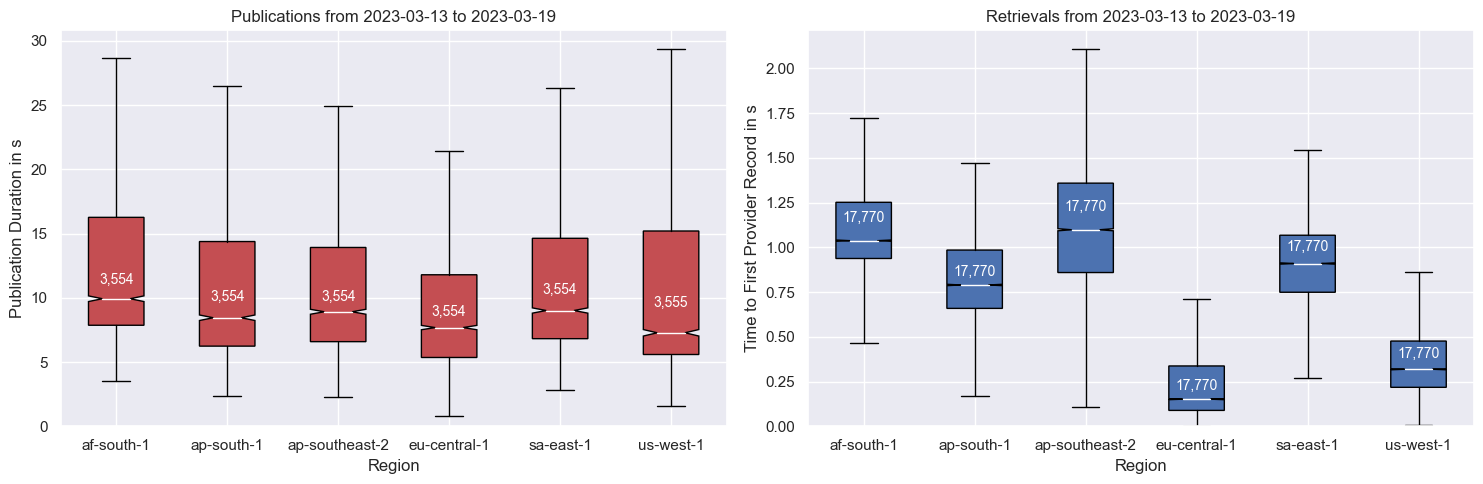

In [10]:
plots = [
    {
        "data": provides,
        "boxcolor": "r",
        "ylabel": "Publication Duration in s",
        "title": "Publications",
    },
    {
        "data": retrievals,
        "boxcolor": "b",
        "ylabel": "Time to First Provider Record in s",
        "title": "Retrievals",
    },
]

regions = list(sorted(retrievals["region"].unique()))

fig, ax = plt.subplots(1, 2, figsize=[15, 5])

for i, plot in enumerate(plots):
    ax = fig.axes[i]

    group = plot['data'].groupby('region')
    data = group['duration'].apply(list)

    bplot = ax.boxplot(data, notch=True, showfliers=False, labels=data.index, patch_artist=True)

    for box in bplot["boxes"]:
        box.set_facecolor(plot["boxcolor"])

    for median in bplot["medians"]:
        median.set_color("white")

    ax.set_title(f"{plot['title']} from {plot['data']['date'].min()} to {plot['data']['date'].max()}")
    ax.set_xlabel("Region")
    ax.set_ylabel(plot['ylabel'])
    ax.set_ylim(0)

    samples = []
    for j, index in enumerate(data.index):
        y = np.percentile(data.loc[index], 60)
        ax.text(j + 1, y, format(len(data.loc[index]), ","), ha="center", fontdict={"fontsize": 10}, color="w")

fig.tight_layout()

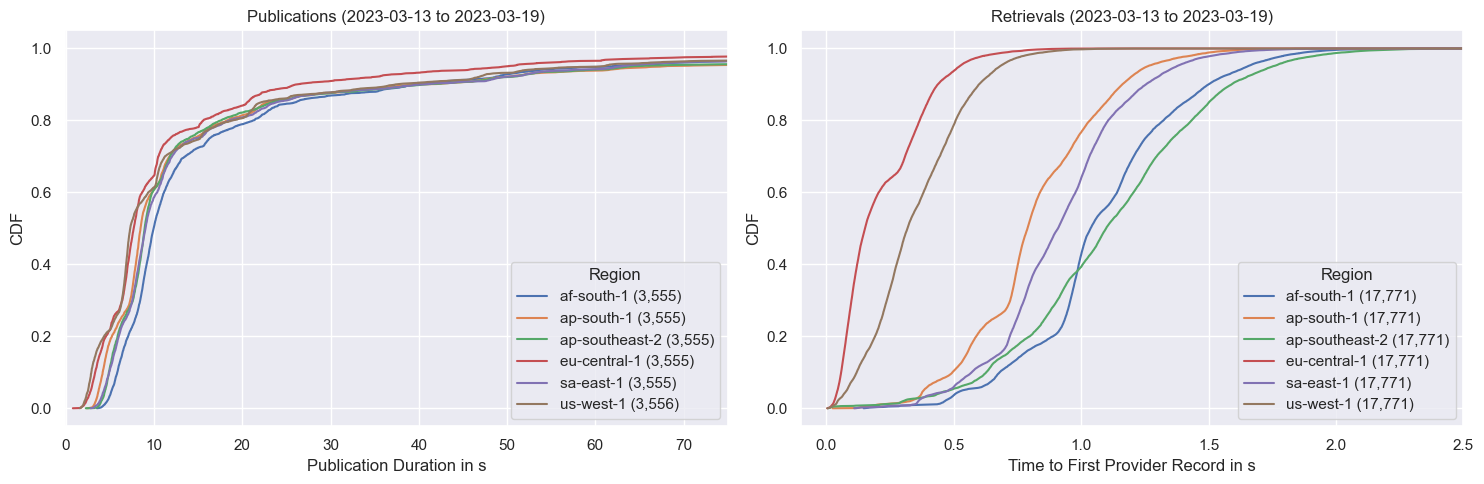

In [11]:
plots = [
    {
        "data": provides,
        "ylabel": "Publication Duration in s",
        "title": "Publications",
        "ymax": 75,
    },
    {
        "data": retrievals,
        "ylabel": "Time to First Provider Record in s",
        "title": "Retrievals",
        "ymax": 2.5,
    },
]

regions = list(sorted(retrievals["region"].unique()))

fig, ax = plt.subplots(1, 2, figsize=[15, 5])

for i, plot in enumerate(plots):
    ax = fig.axes[i]

    group = plot["data"].groupby('region')
    data = group['duration'].apply(list)

    for j, region in enumerate(sorted(plot["data"]["region"].unique())):
        dat = cdf(pd.Series(data.loc[region], name="duration"))
        ax.plot(dat["duration"], dat["cdf"], label=f"{region} ({format(len(dat), ',')})")

    ax.set_xlim(-0.1, plot["ymax"])
    ax.legend(title="Region")
    ax.set_xlabel(plot["ylabel"])
    ax.set_ylabel("CDF")
    ax.set_title(f"{plot['title']} ({plot['data']['date'].min()} to {plot['data']['date'].max()})")

fig.tight_layout()

In [54]:
data = retrievals.groupby(["region"])["has_error"].agg(['mean', 'count']).reset_index()
data

,region,mean,count
0,af-south-1,0.000169,17770
1,ap-south-1,0.000225,17770
2,ap-southeast-2,0.000225,17770
3,eu-central-1,0.000169,17770
4,sa-east-1,0.000225,17770
5,us-west-1,0.000225,17770


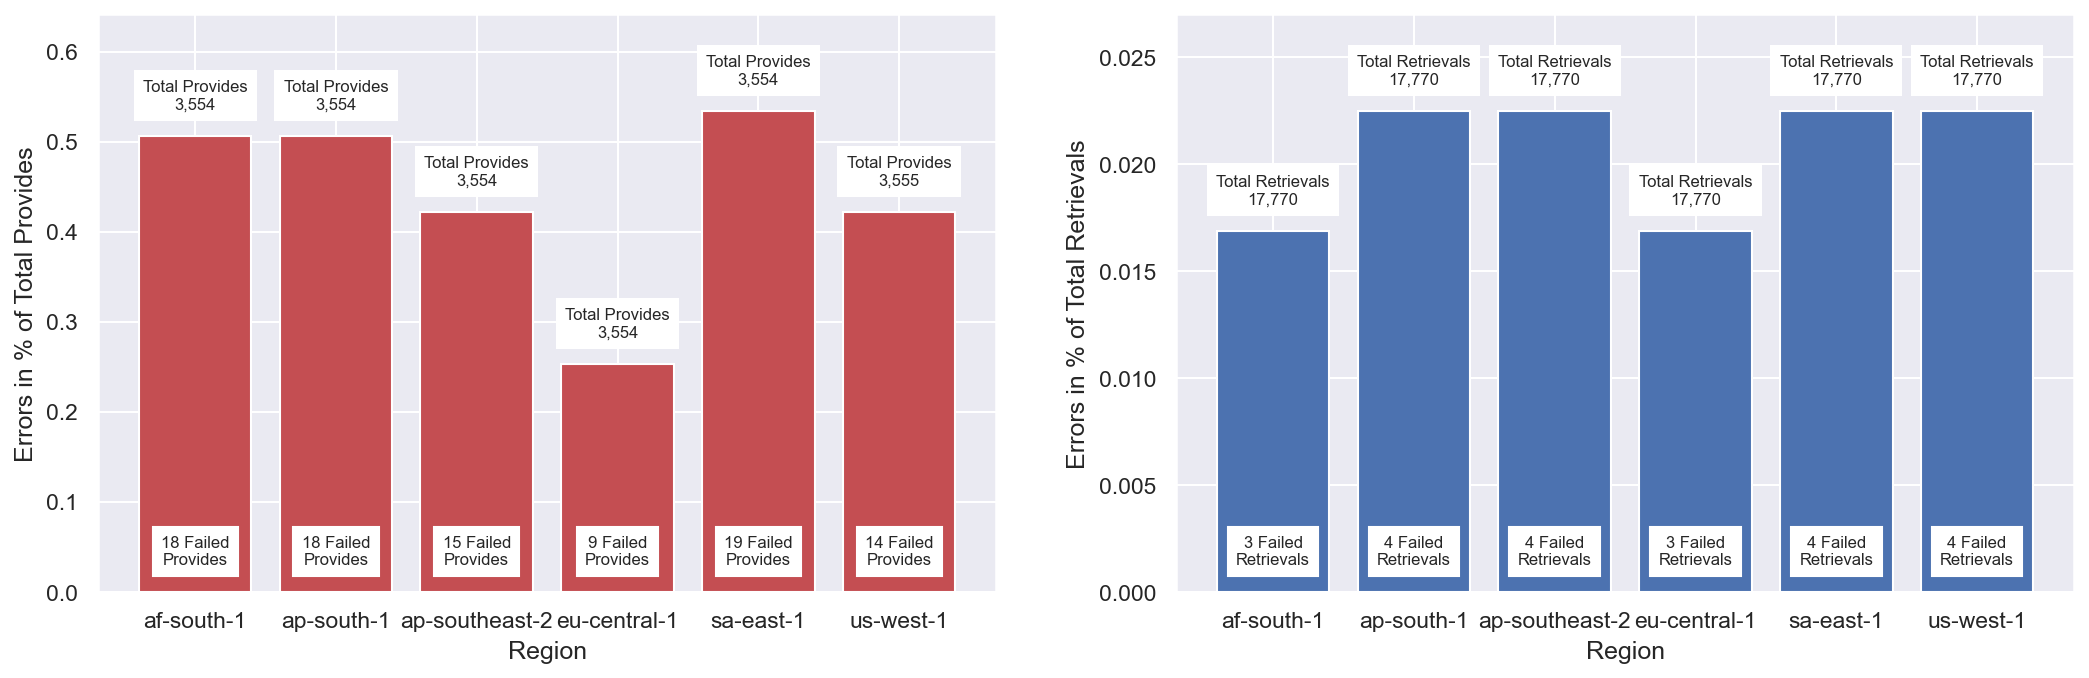

In [99]:
plots = [
    {
        "data": provides,
        "color": "r",
        "type": "Provides",
    },
    {
        "data": retrievals,
        "color": "b",
        "type": "Retrievals",
    }
]

fig, ax = plt.subplots(1, 2, figsize=[17, 5], dpi=150)
for i, plot in enumerate(plots):
    data = plot["data"].groupby(["region"])["has_error"].agg(['mean', 'count']).reset_index()

    ax = fig.axes[i]
    p = ax.bar(data["region"], 100 * data["mean"], color=plot["color"])

    y = 0.05 * data['mean'].max()
    for i, region in enumerate(data["region"]):
        ax.text(i, 100 * (data['mean'][i] + y), f"Total {plot['type']}\n{format(int(data['count'][i]), ',')}",
                ha="center", va="bottom", bbox={"facecolor": 'white'}, fontsize=8)

        ax.text(i, 100 * y, f"{int((data['mean'] * data['count'])[i])} Failed\n{plot['type']}",
                ha="center", va="bottom", bbox={"facecolor": 'white'}, fontsize=8)

    ax.set_ylim(0, 100 * data['mean'].max() * 1.2)
    ax.set_xlabel("Region")
    ax.set_ylabel(f"Errors in % of Total {plot['type']}")

In [102]:
query = f"""
SELECT
    n.region,
    r.duration,
    r.created_at,
    DATE(r.created_at)::TEXT date,
    DATE_PART('week', r.created_at)::INT week,
    r.error IS NOT NULL has_error
FROM retrievals r
    INNER JOIN nodes n ON r.node_id = n.id
WHERE r.created_at >= '2023-03-06'
  AND r.created_at < '{date_max}'
ORDER BY r.created_at
"""
retrievals = pd.read_sql_query(query, con=conn)
retrievals

,region,duration,created_at,date,week,has_error
0,eu-central-1,0.111972,2023-03-06 00:00:28.751845+00:00,2023-03-06,10,False
1,us-west-1,0.386354,2023-03-06 00:00:28.910442+00:00,2023-03-06,10,False
2,ap-south-1,1.078204,2023-03-06 00:00:30.088840+00:00,2023-03-06,10,False
3,ap-southeast-2,1.043488,2023-03-06 00:00:30.110689+00:00,2023-03-06,10,False
4,af-south-1,1.862780,2023-03-06 00:00:31.050360+00:00,2023-03-06,10,False
...,...,...,...,...,...,...
210431,us-west-1,0.212420,2023-03-19 23:59:03.507075+00:00,2023-03-19,11,False
210432,eu-central-1,0.298543,2023-03-19 23:59:03.623025+00:00,2023-03-19,11,False
210433,ap-south-1,0.800439,2023-03-19 23:59:04.220889+00:00,2023-03-19,11,False
210434,sa-east-1,1.038245,2023-03-19 23:59:04.384071+00:00,2023-03-19,11,False


In [199]:
query = f"""
SELECT
    n.region,
    p.duration,
    p.created_at,
    DATE(p.created_at)::TEXT date,
    DATE_PART('week', p.created_at)::INT week,
    p.error IS NOT NULL has_error
FROM provides p
    INNER JOIN nodes n ON p.node_id = n.id
WHERE p.created_at >= '2023-03-06'
  AND p.created_at < '{date_max}'
ORDER BY p.created_at
"""
provides = pd.read_sql_query(query, con=conn)
provides

,region,duration,created_at,date,week,has_error
0,sa-east-1,122.347621,2023-03-06 00:00:18.270073+00:00,2023-03-06,10,False
1,ap-south-1,9.041665,2023-03-06 00:00:40.846833+00:00,2023-03-06,10,False
2,ap-southeast-2,4.406370,2023-03-06 00:00:58.252887+00:00,2023-03-06,10,False
3,af-south-1,8.134784,2023-03-06 00:01:18.949442+00:00,2023-03-06,10,False
4,us-west-1,6.847360,2023-03-06 00:01:37.417741+00:00,2023-03-06,10,False
...,...,...,...,...,...,...
42093,eu-central-1,7.813193,2023-03-19 23:58:02.233044+00:00,2023-03-19,11,False
42094,ap-southeast-2,5.853802,2023-03-19 23:58:19.619717+00:00,2023-03-19,11,False
42095,ap-south-1,3.627227,2023-03-19 23:58:35.167957+00:00,2023-03-19,11,False
42096,af-south-1,6.529010,2023-03-19 23:58:53.230564+00:00,2023-03-19,11,False


In [142]:
percentiles = [0.5, 0.90, 0.99]
df = retrievals[["region", "week", "duration"]].groupby(["region", "week"])["duration"].quantile(percentiles).unstack()
pct_diff = df[percentiles].groupby('region', group_keys=True).apply(lambda x: x.pct_change())
pct_diff = pct_diff.reset_index(level=0, drop=True)
df = pd.concat([df, pct_diff.add_suffix('_pct_diff')], axis=1).reset_index()
df

,region,week,0.5,0.9,0.99,0.5_pct_diff,0.9_pct_diff,0.99_pct_diff
0,af-south-1,10,1.060966,1.580543,2.050898,NaN,NaN,NaN
1,af-south-1,11,1.036865,1.499437,1.889071,-0.022716,-0.051316,-0.078905
2,ap-south-1,10,0.830229,1.241299,1.651955,NaN,NaN,NaN
3,ap-south-1,11,0.789283,1.161118,1.519567,-0.049320,-0.064594,-0.080140
4,ap-southeast-2,10,1.078858,1.542506,1.999479,NaN,NaN,NaN
5,ap-southeast-2,11,1.097779,1.590726,2.050176,0.017538,0.031261,0.025355
6,eu-central-1,10,0.197024,0.505110,0.839043,NaN,NaN,NaN
7,eu-central-1,11,0.151251,0.437458,0.716422,-0.232324,-0.133936,-0.146143
8,sa-east-1,10,0.930831,1.324384,1.703426,NaN,NaN,NaN
9,sa-east-1,11,0.909194,1.253586,1.612416,-0.023245,-0.053457,-0.053428


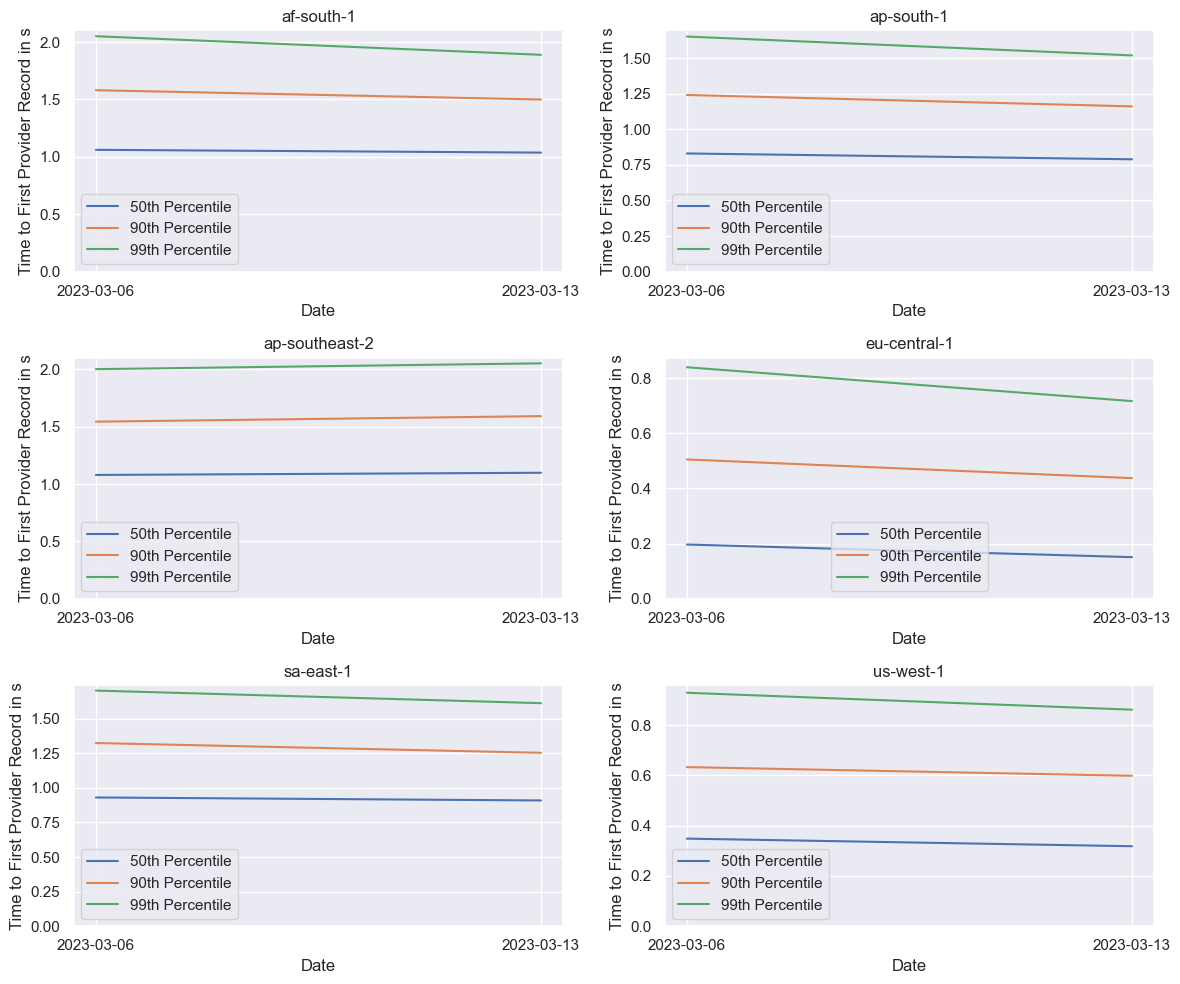

In [150]:

regions = list(sorted(df["region"].unique()))

fig, ax = plt.subplots(len(regions) // 2 + len(regions) % 2, 2, figsize=[12, 10])

for i, region in enumerate(regions):
    ax = fig.axes[i]
    data = df[df["region"] == region]

    mondays = list(map(lambda week: monday_of_week(week), data["week"]))
    for percentile in percentiles:
        ax.plot(mondays, data[percentile], label=f"{int(100 * percentile)}th Percentile")

    ax.set_xticks(np.unique(mondays))
    ax.set_ylim(0)
    ax.set_xlabel("Date")
    ax.set_ylabel("Time to First Provider Record in s")
    ax.legend()
    ax.set_title(f"{region}")

fig.tight_layout()

0.5       0.9      0.99  0.5_pct_diff  0.9_pct_diff  \
region         week                                                             
af-south-1     10    1.060966  1.580543  2.050898           NaN           NaN   
               11    1.036865  1.499437  1.889071     -0.022716     -0.051316   
ap-south-1     10    0.830229  1.241299  1.651955           NaN           NaN   
               11    0.789283  1.161118  1.519567     -0.049320     -0.064594   
ap-southeast-2 10    1.078858  1.542506  1.999479           NaN           NaN   
               11    1.097779  1.590726  2.050176      0.017538      0.031261   
eu-central-1   10    0.197024  0.505110  0.839043           NaN           NaN   
               11    0.151251  0.437458  0.716422     -0.232324     -0.133936   
sa-east-1      10    0.930831  1.324384  1.703426           NaN           NaN   
               11    0.909194  1.253586  1.612416     -0.023245     -0.053457   
us-west-1      10    0.348667  0.633336  0.929223           NaN           NaN   
               11    0.318417  0.598784  0.861823     -0.086760     -0.054554   

                     0.99_pct_diff  
region         week                 
af-south-1     10              NaN  
               11        -0.078905  
ap-south-1     10              NaN  
               11        -0.080140  
ap-southeast-2 10              NaN  
               11         0.025355  
eu-central-1   10              NaN  
               11        -0.146143  
sa-east-1      10              NaN  
               11        -0.053428  
us-west-1      10              NaN  
               11        -0.072534

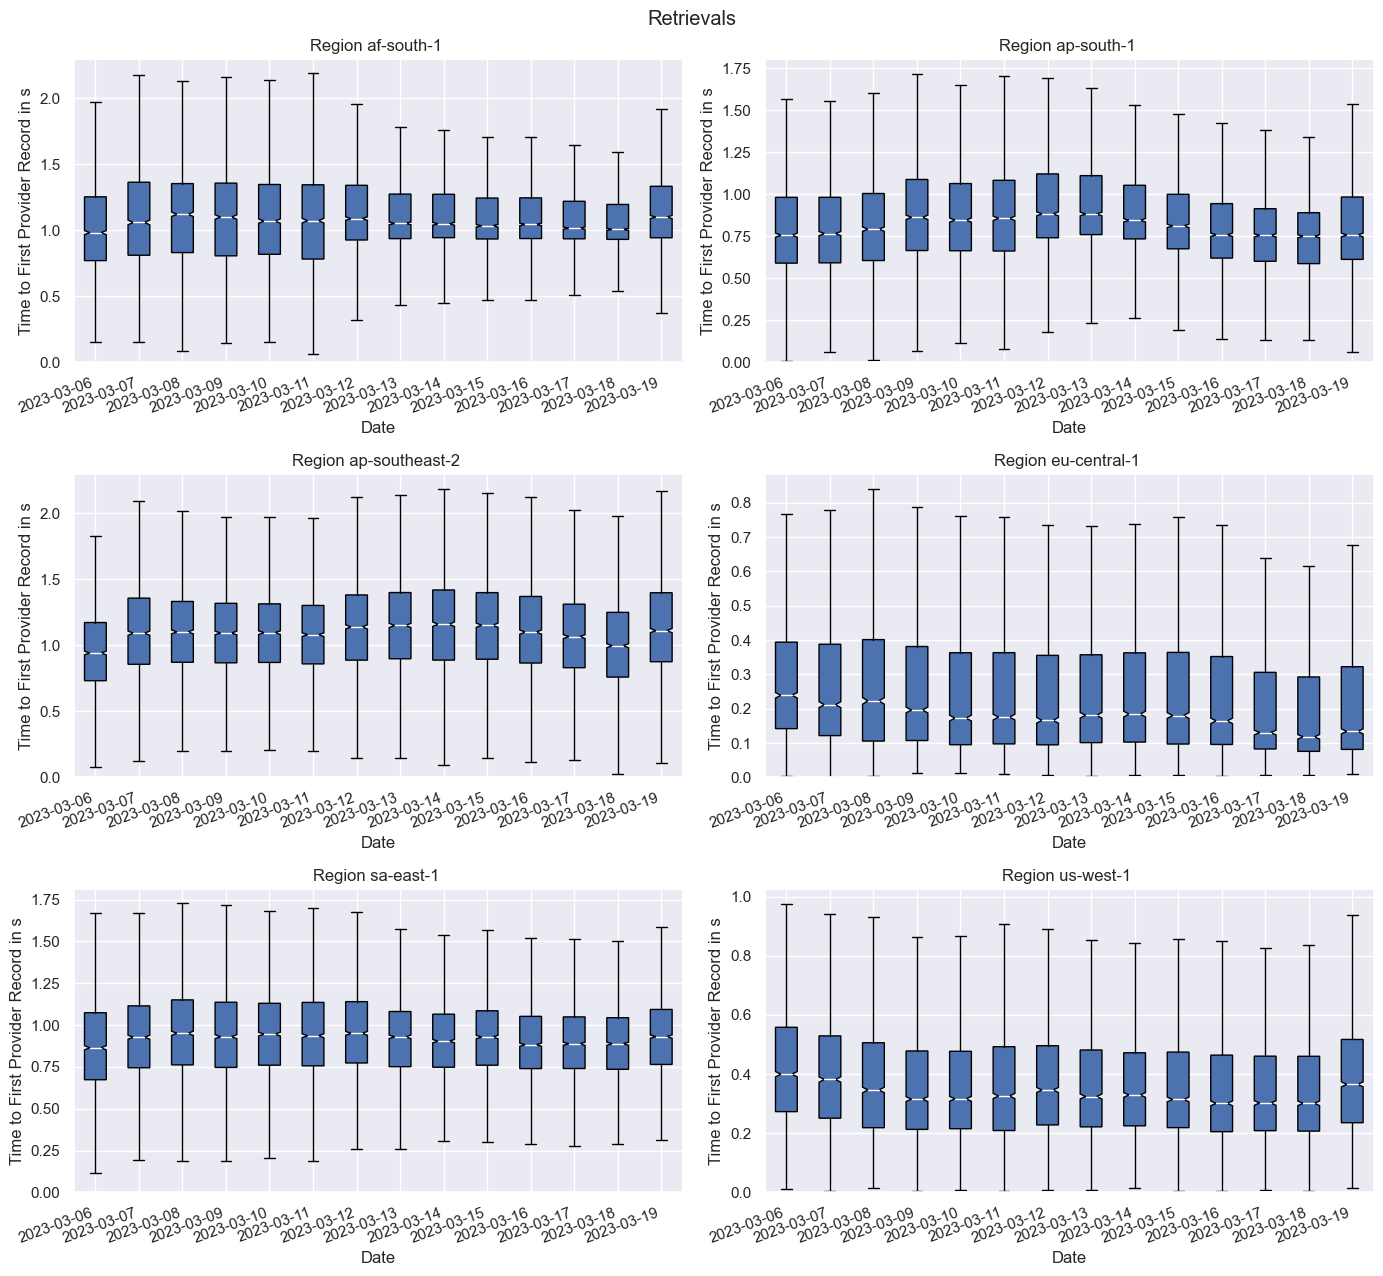

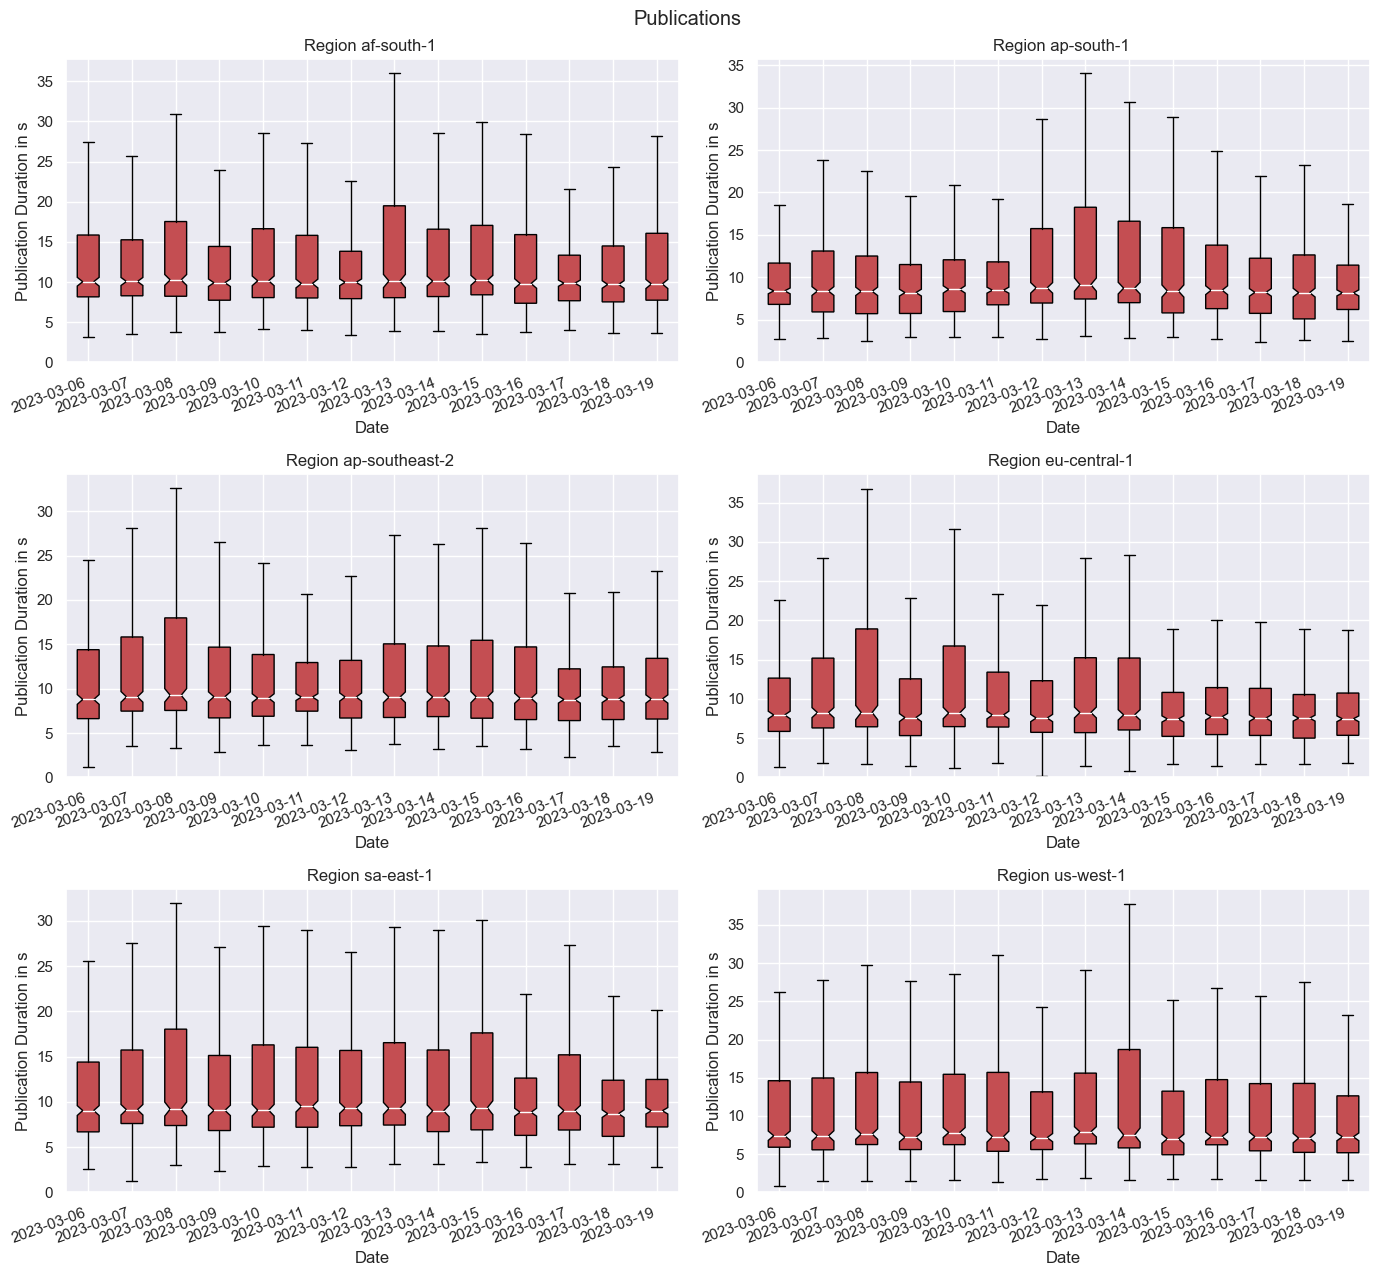

In [207]:
plots = [
    {
        "data": retrievals,
        "boxcolor": "b",
        "ylabel": "Time to First Provider Record in s",
        "title": "Retrievals"
    },
    {
        "data": provides,
        "boxcolor": "r",
        "ylabel": "Publication Duration in s",
        "title": "Publications"
    },
]

for plot in plots:
    regions = list(sorted(plot["data"]["region"].unique()))

    fig, ax = plt.subplots(len(regions) // 2 + len(regions) % 2, 2, figsize=[14, 13])

    for i, region in enumerate(regions):
        ax = fig.axes[i]

        group = plot["data"][plot["data"]["region"] == region].groupby('date')
        data = group['duration'].apply(list)

        bplot = ax.boxplot(data, notch=True, showfliers=False, labels=data.index, patch_artist=True)

        for box in bplot["boxes"]:
            box.set_facecolor(plot["boxcolor"])
        for median in bplot["medians"]:
            median.set_color("white")

        ax.set_xlabel("Date")
        ax.set_title(f"Region {region} ")
        ax.set_ylabel(plot["ylabel"])
        ax.set_ylim(0)

        for tick in ax.get_xticklabels():
            tick.set_rotation(20)
            tick.set_ha("right")

    fig.suptitle(plot["title"])
    fig.tight_layout()

In [152]:
percentiles = [0.5, 0.90, 0.99]
df = retrievals[["region", "week", "duration"]].groupby(["region", "week"])["duration"].quantile(percentiles).unstack()
pct_diff = df[percentiles].groupby('region', group_keys=True).apply(lambda x: x.pct_change())
pct_diff = pct_diff.reset_index(level=0, drop=True)
df = pd.concat([df, pct_diff.add_suffix('_pct_diff')], axis=1).reset_index()
df

,region,week,0.5,0.9,0.99,0.5_pct_diff,0.9_pct_diff,0.99_pct_diff
0,af-south-1,10,1.060966,1.580543,2.050898,NaN,NaN,NaN
1,af-south-1,11,1.036865,1.499437,1.889071,-0.022716,-0.051316,-0.078905
2,ap-south-1,10,0.830229,1.241299,1.651955,NaN,NaN,NaN
3,ap-south-1,11,0.789283,1.161118,1.519567,-0.049320,-0.064594,-0.080140
4,ap-southeast-2,10,1.078858,1.542506,1.999479,NaN,NaN,NaN
5,ap-southeast-2,11,1.097779,1.590726,2.050176,0.017538,0.031261,0.025355
6,eu-central-1,10,0.197024,0.505110,0.839043,NaN,NaN,NaN
7,eu-central-1,11,0.151251,0.437458,0.716422,-0.232324,-0.133936,-0.146143
8,sa-east-1,10,0.930831,1.324384,1.703426,NaN,NaN,NaN
9,sa-east-1,11,0.909194,1.253586,1.612416,-0.023245,-0.053457,-0.053428


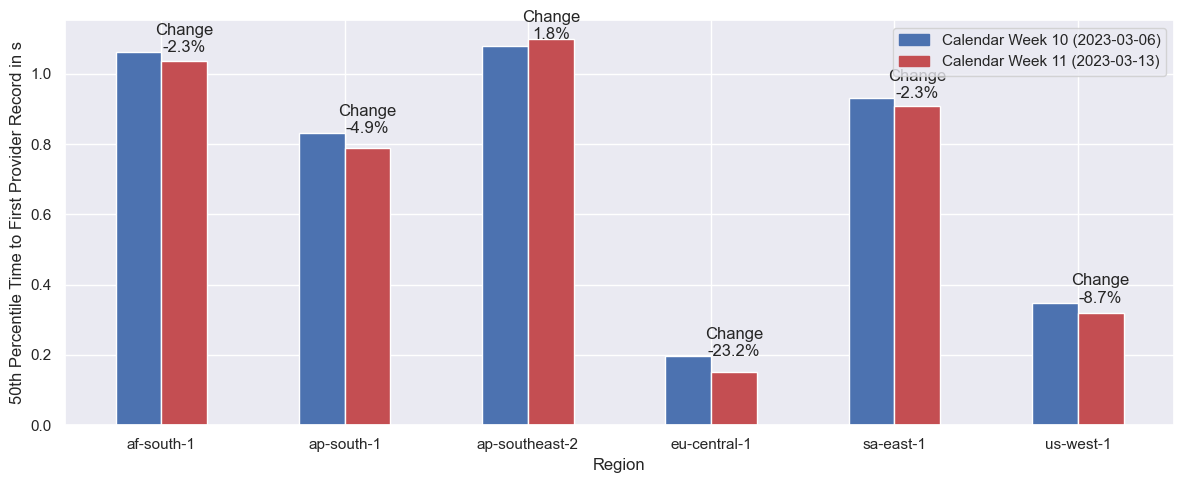

In [195]:
regions = list(sorted(df["region"].unique()))

width = 0.25
fig, ax = plt.subplots(figsize=[12, 5])

percentile = 0.5

previous_week = int(df['week'].max()-1)
latest_week = int(df['week'].max())


for i, region in enumerate(regions):
    data = df[df["region"] == region]

    data_latest_week = data[data["week"] == latest_week]
    data_previous_week = data[data["week"] == previous_week]


    ax.bar(i - width / 2, data_previous_week[percentile], width=width, color="b")
    ax.bar(i + width / 2, data_latest_week[percentile], width=width, color="r")

    change_pct = 100 * (data_latest_week[percentile].iloc[0] / data_previous_week[percentile].iloc[0] - 1)
    ax.text(i + width / 2, max(data_latest_week[percentile].iloc[0], data_previous_week[percentile].iloc[0]), f"Change\n{change_pct:.1f}%", ha="center")

ax.set_xticks(np.arange(0, len(regions)))
ax.set_xticklabels(regions)
ax.set_xlabel("Region")
ax.set_ylabel("50th Percentile Time to First Provider Record in s")

legend_elements = [
    Patch(facecolor='b', edgecolor='b', label=f"Calendar Week {previous_week} ({monday_of_week(previous_week)})"),
    Patch(facecolor='r', edgecolor='r', label=f"Calendar Week {latest_week} ({monday_of_week(latest_week)})")
]

ax.legend(handles=legend_elements)

fig.tight_layout()

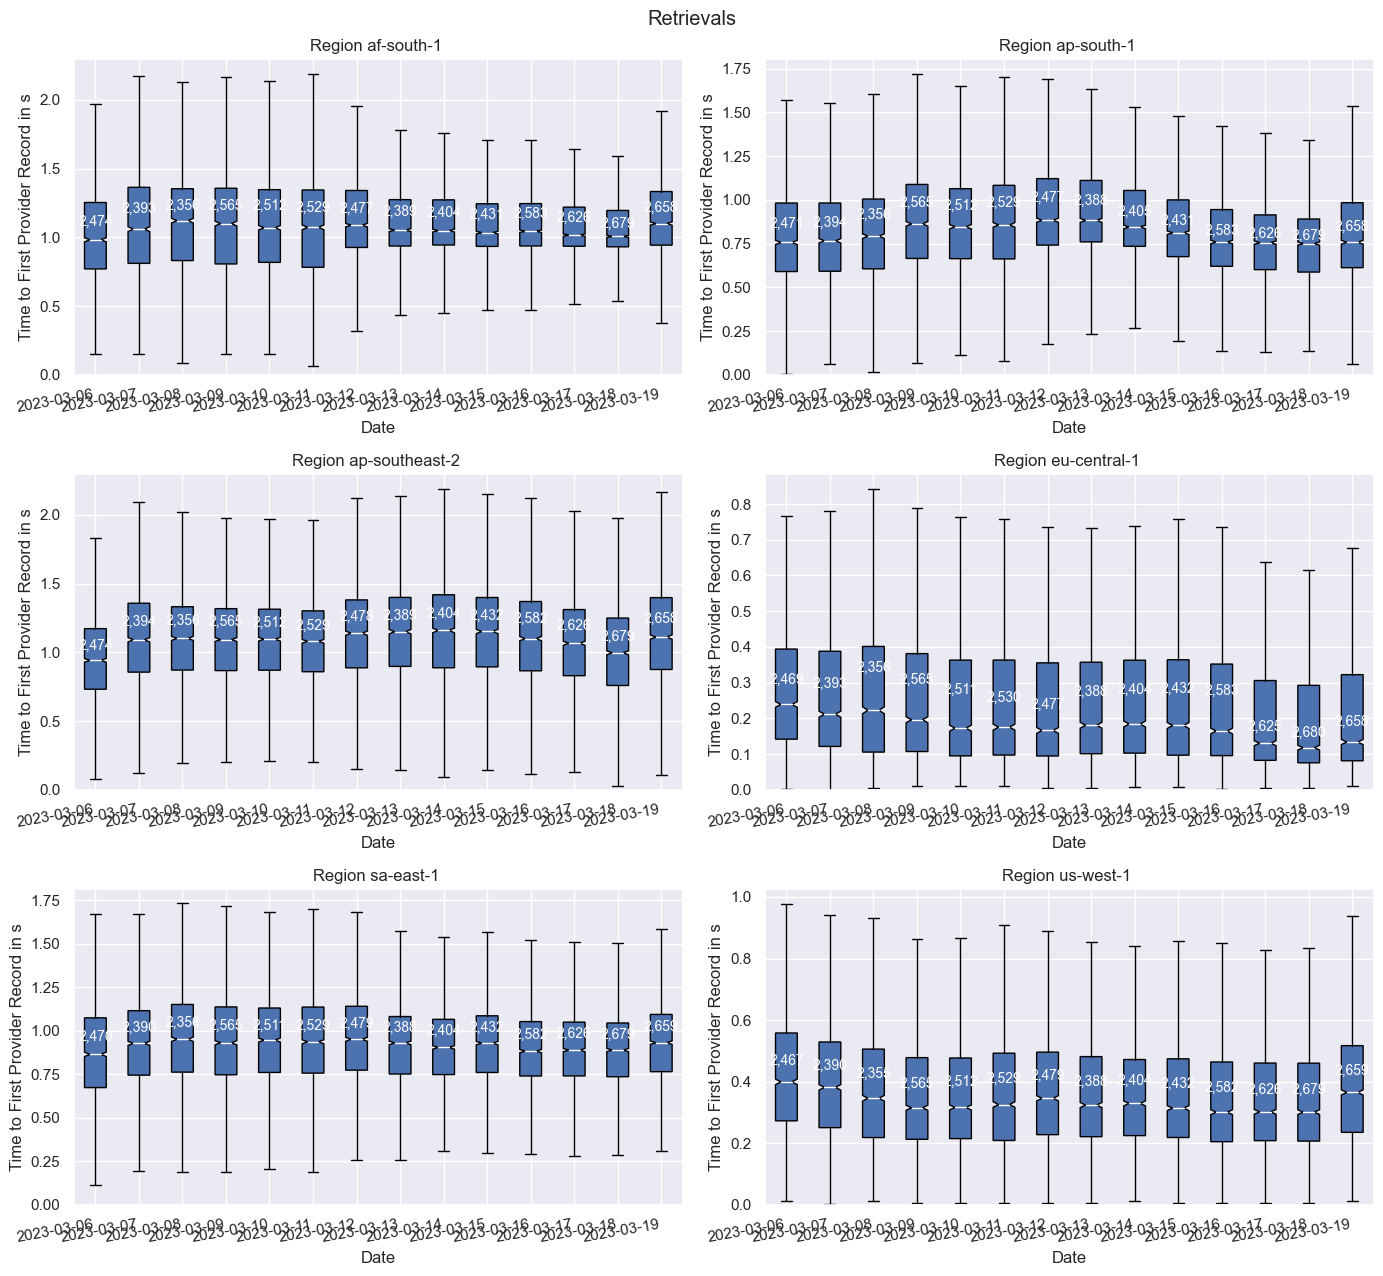

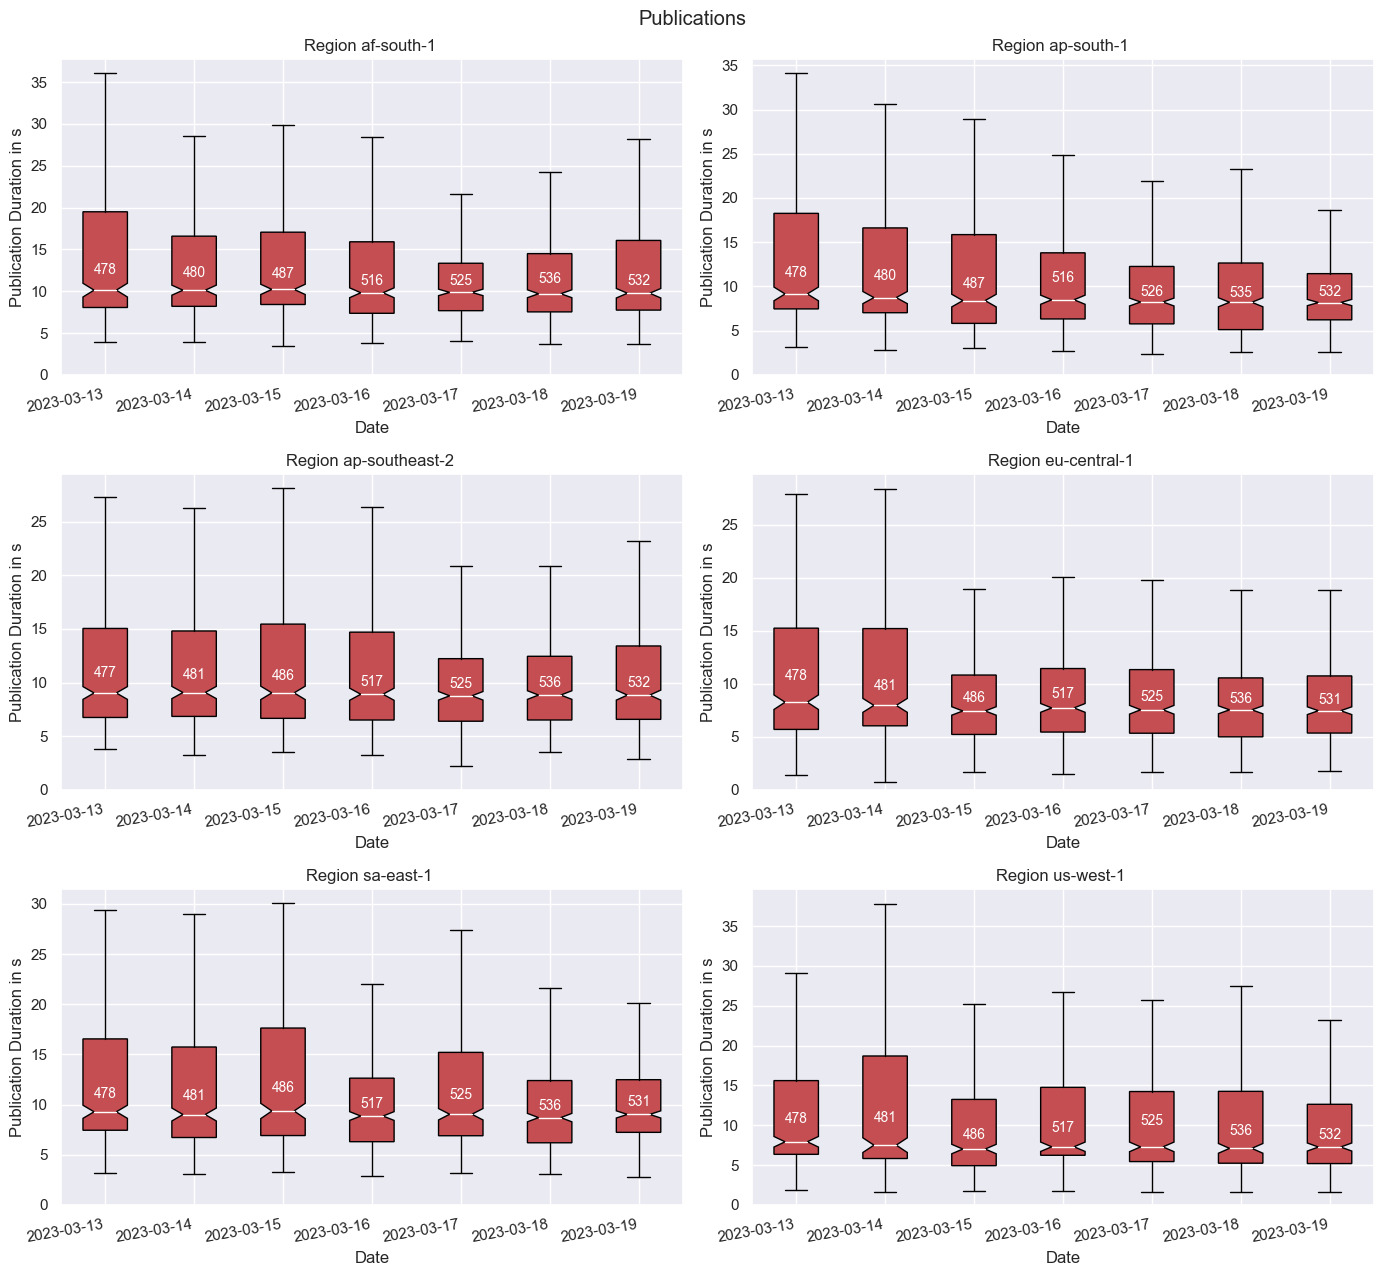

In [196]:
plots = [
    {
        "data": retrievals,
        "boxcolor": "b",
        "ylabel": "Time to First Provider Record in s",
        "title": "Retrievals"
    },
    {
        "data": provides,
        "boxcolor": "r",
        "ylabel": "Publication Duration in s",
        "title": "Publications"
    },
]

for plot in plots:
    regions = list(sorted(plot["data"]["region"].unique()))

    fig, ax = plt.subplots(len(regions) // 2 + len(regions) % 2, 2, figsize=[14, 13])

    for i, region in enumerate(regions):
        ax = fig.axes[i]

        group = plot["data"][plot["data"]["region"] == region].groupby('date')
        data = group['duration'].apply(list)

        bplot = ax.boxplot(data, notch=True, showfliers=False, labels=data.index, patch_artist=True)

        for box in bplot["boxes"]:
            box.set_facecolor(plot["boxcolor"])
        for median in bplot["medians"]:
            median.set_color("white")

        ax.set_xlabel("Date")
        ax.set_title(f"Region {region} ")
        ax.set_ylabel(plot["ylabel"])
        ax.set_ylim(0)

        samples = []
        for j, index in enumerate(data.index):
            y = np.percentile(data.loc[index], 60)
            ax.text(j + 1, y, format(len(data.loc[index]), ","), ha="center", fontdict={"fontsize": 10}, color="w")

        for tick in ax.get_xticklabels():
            tick.set_rotation(10)
            tick.set_ha("right")
    fig.suptitle(plot["title"])
    fig.tight_layout()